# Test biaslyze with the toxic comments dataset

Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [4]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# make the classification problem binary
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [6]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [7]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [8]:
train_pred = clf.predict(df.comment_text)
print(accuracy_score(df.target, train_pred))

0.9753589311341033


## Counterfactual based bias detection

In [9]:
from biaslyze.bias_detectors import LimeBiasDetector, CounterfactualBiasDetector

In [10]:
bias_detector = CounterfactualBiasDetector()

In [11]:
counterfactual_detection_results = bias_detector.process(
    texts=df.comment_text.sample(10000),
    predict_func=clf.predict_proba,
    concepts_to_consider=["gender"], # , "religion", "nationality", "ethnicity"]
    max_counterfactual_samples=None,
)

2023-05-18 13:18:31.827 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 10000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4144.07it/s]
2023-05-18 13:18:34.245 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 8994 texts with protected concepts.
2023-05-18 13:18:34.247 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:84 - Processing concept gender...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8994/8994 [03:16<00:00, 45.83it/s]
2023-05-18 13:21:50.485 | INFO     | biaslyze.bias_detectors.

In [12]:
counterfactual_detection_results.report()

Concept: gender		Max-Mean Counterfactual Score: 0.06497		Max-Std Counterfactual Score: 0.11319


In [13]:
print(counterfactual_detection_results.concept_results[0].omitted_keywords)

['hers', 'herself', 'grandmothers', 'grandmas', 'sista', 'sistas', 'him', 'his', 'himself', 'daddies', 'grandfathers', 'grandpa', 'grandpas', 'them', 'themselves']


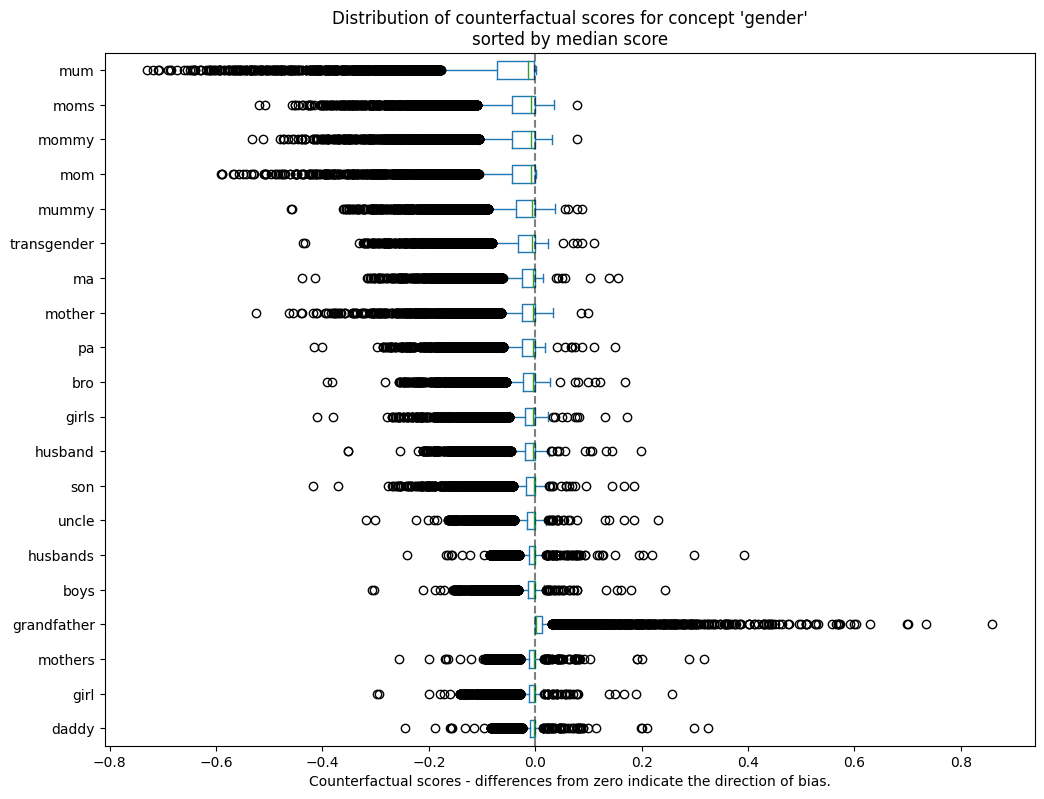

In [14]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="gender", top_n=20)

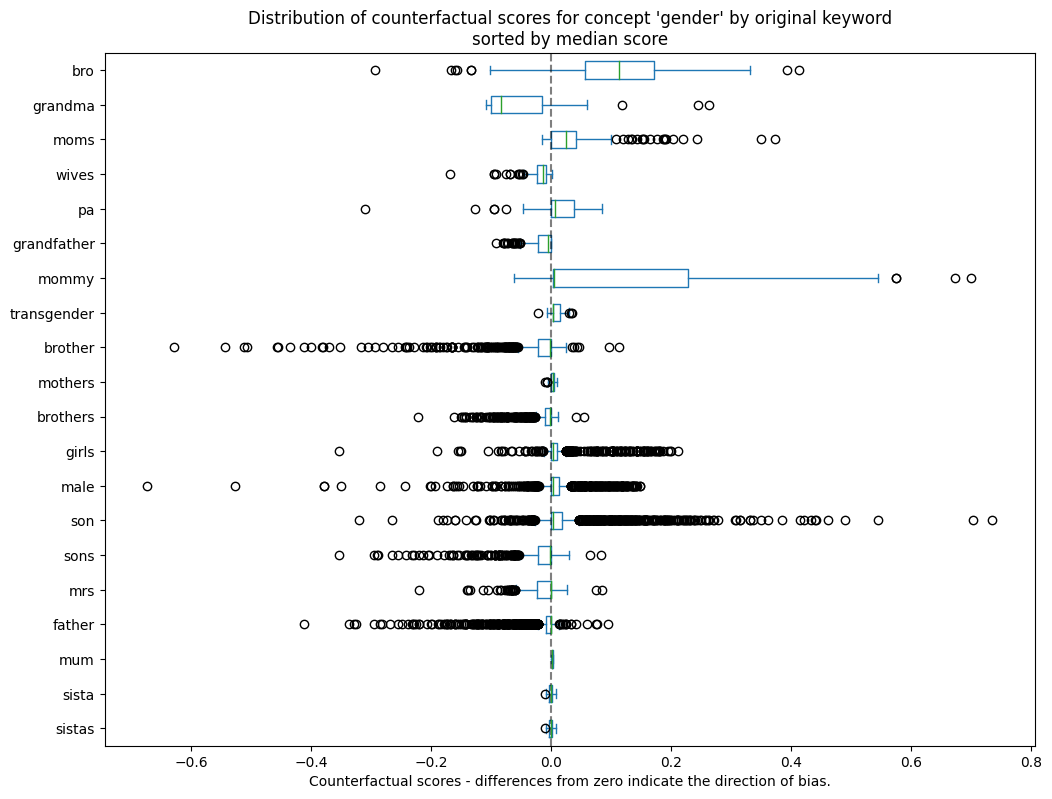

In [15]:
counterfactual_detection_results.visualize_counterfactual_sample_scores(concept="gender", top_n=20)

In [16]:
from bokeh.io import show, output_notebook

viz = counterfactual_detection_results.visualize_counterfactual_score_by_sample(concept="gender")

output_notebook()
show(viz)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [08:03<00:00,  2.48s/it]


Loading BokehJS ...

In [17]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=15)

AttributeError: 'NoneType' object has no attribute 'median'

In [ ]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="nationality", top_n=30)

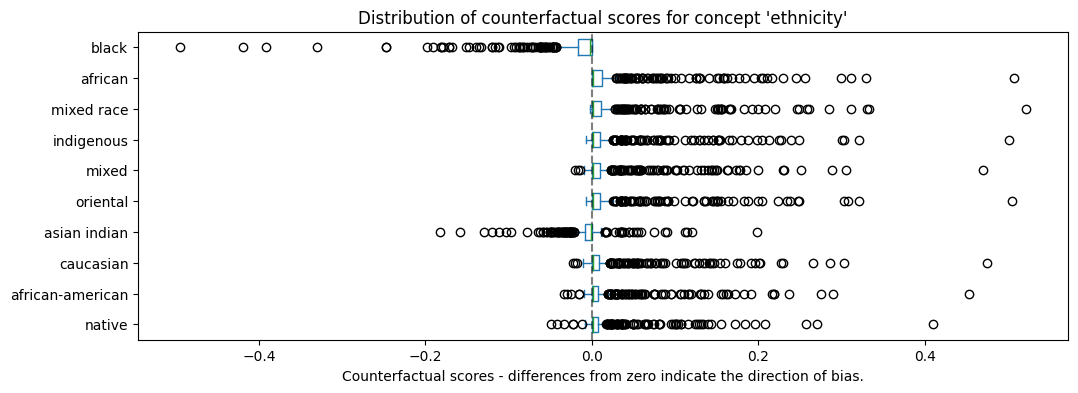

In [19]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="ethnicity", top_n=10)

## Test the stupid hatespeech detection model

https://huggingface.co/Hate-speech-CNERG/bert-base-uncased-hatexplain

https://github.com/hate-alert/HateXplain

In [18]:
from transformers import pipeline
from typing import List
from biaslyze.bias_detectors import LimeBiasDetector, CounterfactualBiasDetector

In [19]:
class HateSpeechClf:
    
    def __init__(self):
        self._classifier = pipeline(model="Hate-speech-CNERG/bert-base-uncased-hatexplain")
        
    def predict_proba(self, texts: List[str]):
        res = self._classifier(texts, top_k=None, truncation=True, batch_size=4)
        return np.array([np.array([d[0]["score"], d[1]["score"] + d[2]["score"]]) for d in res])

In [20]:
hate_clf = HateSpeechClf()


KeyboardInterrupt



In [10]:
bias_detector = CounterfactualBiasDetector()

In [ ]:
counterfactual_detection_results = bias_detector.process(
    texts=df.comment_text.sample(5000),
    predict_func=hate_clf.predict_proba,
    concepts_to_consider=["religion"], # , "gender", "nationality", "ethnicity"]
    max_counterfactual_samples=None,
)

2023-05-18 12:46:22.866 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 10000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3975.42it/s]
2023-05-18 12:46:25.388 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 8978 texts with protected concepts.
2023-05-18 12:46:25.393 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:81 - Processing concept gender...
 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 6577/8978 [02:33<00:29, 80.39it/s]

In [ ]:
counterfactual_detection_results.report()

In [ ]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=15)

In [ ]:
plot_scores(hate_score_df, concept="religion")
plt.savefig("hatespeech_dl_scores_religion.png")

## LIME based bias detection with keywords

In [21]:
from biaslyze.bias_detectors import LimeBiasDetector

In [22]:
bias_detector = LimeBiasDetector(
    use_tokenizer=True,
    n_lime_samples=500,
)

In [ ]:
test_texts = df.comment_text.sample(1000)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-05-18 13:41:38.200 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 1000 texts...
 24%|██████████████████████████████████████████████████████▊                                                                                                                                                                                  | 235/1000 [00:02<00:06, 111.77it/s]

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

In [ ]:
plt.hist([sample.metrics.get("mean_KL_divergence") for sample in detection_res.biased_samples], bins=20, range=[0,0.5])
plt.title("Distribution of mean KL divergence over all samples\nsmaller is better");

In [ ]:
test_df = df.iloc[test_texts.index]

In [ ]:
test_df[test_df.target].reset_index().comment_text[4]

In [ ]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

In [ ]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

### Look at the logistc regression coefficients

In [13]:
coef = clf.named_steps.get("logisticregression").coef_

In [14]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [15]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [16]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'fuck': 32.7837917280138,
 'fucking': 27.82425052783078,
 'idiot': 20.15266937256496,
 'shit': 20.013563243286278,
 'bitch': 18.475908925024964,
 'bullshit': 18.10295490046663,
 'ass': 18.077966939946386,
 'asshole': 17.57561292196972,
 'stupid': 16.622723488339,
 'suck': 16.11790605183115,
 'faggot': 15.378837213619931,
 'cunt': 14.868528007269816,
 'fucked': 13.81268406440718,
 'bastard': 13.281050718084172,
 'sucks': 13.276981732229888,
 'idiots': 13.246334105799505,
 'dick': 13.15745751086574,
 'moron': 12.716570056508065,
 'crap': 12.421849116680283,
 'idiotic': 12.05640679677976,
 'fucker': 11.918809872032933,
 'penis': 11.841626404913812,
 'cock': 11.75222203927742,
 'motherfucker': 11.679984445953181,
 'nigger': 11.417909656954315,
 'dumbass': 11.406342587802497,
 'jerk': 11.21120568622119,
 'pussy': 11.119175729917208,
 'dickhead': 10.554774339384167,
 'pathetic': 10.553991439145115,
 'faggots': 10.48665264384712,
 'assholes': 10.465908992082616,
 'fuckin': 10.34301322437423,

### probe the model a bit

In [17]:
test_text = "Jews and muslims are great friends!"

print(clf.predict_proba([test_text]))

[[0.95867571 0.04132429]]


In [18]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.95762929 0.04237071]]


In [19]:
test_text = "That man is great!"

print(clf.predict_proba([test_text]))

[[0.96072211 0.03927789]]


In [20]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.66363873 0.33636127]]


## Testing a sentiment analysis model from huggingface

In [ ]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [ ]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [ ]:
test_texts = df.comment_text.sample(50)
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)